# Exploratory Analysis On Wellness Data

In this notebook, we will explore the wellness data with the goal of finding a summary measure for wellness. This will let us explore the relationship between wellness, training load, and performance.

## Install Unusual Packages

We use some non-standard packages in our analysis so we want to make sure those packages are installed on the machine running these notebooks. Note that we assume the use on anaconda to run the notebooks so we install packages using `conda`. If you would rather install packages using `pip`, replace the commands below with something of the form: `!{sys.executable} -m pip install <package_name>`.

In [1]:
import sys
!conda install -c desilinguist --yes --prefix {sys.prefix} factor_analyzer
!conda install --yes --prefix {sys.prefix} pingouin

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [2]:
import os
import warnings
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr, ttest_ind, ttest_rel
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
np.random.seed(5151)

## Ensure Processed Data Folder Exists

Since this is the first notebook to be ran, we must create the processed data folder if it is not present.

In [3]:
if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

## Load Data

In [4]:
wellness_df = pd.read_csv('https://www.dropbox.com/s/170bc3dimgn8ru8/wellness.csv?dl=1')
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [5]:
wellness_df.shape

(5011, 19)

To start with, we have 5011 wellness observations.

## Cleaning and Visualizing Data

In [6]:
def plot_histogram(column_name):
    plt.bar(np.sort(wellness_df[column_name].unique()), wellness_df[column_name].value_counts().sort_index())
    plt.title('Distribution of {}'.format(column_name))
    plt.show()

### Fatigue

In [7]:
wellness_df['Fatigue'].value_counts()

4    2003
3    1721
2     642
5     301
1     187
6     150
7       7
Name: Fatigue, dtype: int64

Based on the codebook, 1 is most tired and 7 is most fresh. The scales are:  
1 -> Exhausted  
4 -> Average  
7 -> Fresher than usual  

Thus, the values above make sense with average being most common and 1 less than average being second most common.

In [8]:
wellness_df[wellness_df['Fatigue'].isnull()].shape

(0, 19)

There are no rows missing Fatigue data.

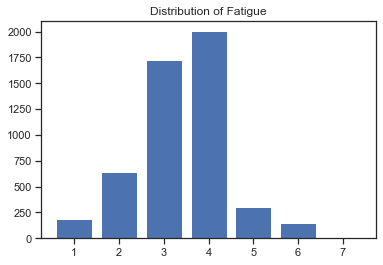

In [9]:
plot_histogram('Fatigue')


Based on the histogram above, we see that the fatigue values are approximately normally distributed.

### Soreness, Desire, Irritability and Sleep Hours

All of these columns are on the same scale as fatigue so we just need to make sure there are no missing values and we can continue using the raw values as with Fatigue.

In [10]:
wellness_df['Soreness'].value_counts()

4    1843
3    1831
2     737
5     280
1     176
6     128
7      16
Name: Soreness, dtype: int64

In [11]:
wellness_df[wellness_df['Soreness'].isnull()].shape

(0, 19)

There are no rows missing Soreness data.

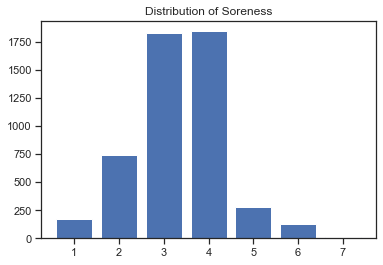

In [12]:
plot_histogram('Soreness')


In [13]:
wellness_df['Desire'].value_counts()

4    3023
3     820
5     428
2     300
6     228
1     159
7      53
Name: Desire, dtype: int64

In [14]:
wellness_df[wellness_df['Desire'].isnull()].shape

(0, 19)

There are no rows missing Desire data.

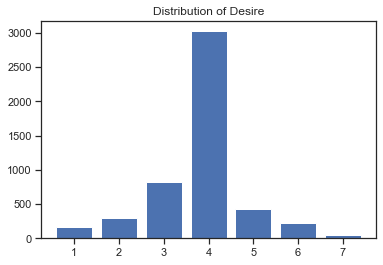

In [15]:
plot_histogram('Desire')


In [16]:
wellness_df['Irritability'].value_counts()

4    3597
3     650
5     347
6     180
2     135
7      61
1      41
Name: Irritability, dtype: int64

In [17]:
wellness_df[wellness_df['Irritability'].isnull()].shape

(0, 19)

There are no rows missing Irritability data.

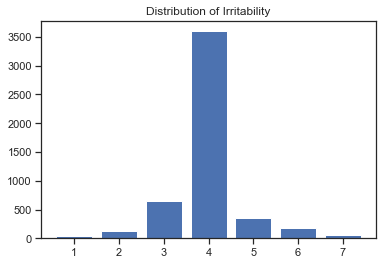

In [18]:
plot_histogram('Irritability')


In [19]:
wellness_df['SleepQuality'].value_counts()

4    2505
3    1037
5     508
2     386
6     242
1     193
7     140
Name: SleepQuality, dtype: int64

In [20]:
wellness_df[wellness_df['SleepQuality'].isnull()].shape

(0, 19)

There are no rows missing SleepQuality data.

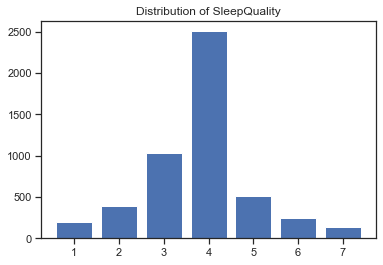

In [21]:
plot_histogram('SleepQuality')

No missing values so all these columns can be used as is.

### Distribution Of Monitor Score Components

All of the monitor score components follow a normal distribution with a mean at the average value of 4. Soreness and Fatigue tend to have more lower values below 4. Sleep Quality has a similar pattern to a lesser degree while Desire and Irritability are more peaked around the mean of 4.

### BedTime, WakeTime, and SleepHours

If we have Sleep Hours, it seems like we do not need Bed Time and Wake Time as wellness would be affected by the amount of sleep and not the particular time players went to bed. So, I will removed the `BedTime` and `Waketime` columns from the dataframe.

In [22]:
wellness_df = wellness_df.drop(columns=['BedTime', 'WakeTime'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [23]:
wellness_df['SleepHours'].mean()

8.661893833566154

In [24]:
wellness_df['SleepHours'].std()

1.418457325102741

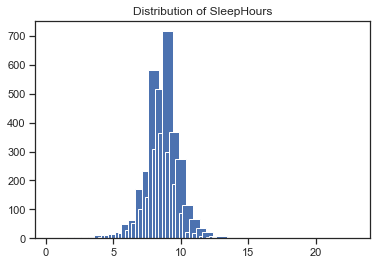

In [25]:
plot_histogram('SleepHours')


The distribution is very peaked around 8.5 hours of sleep, similar to some of the other concentrated wellness variables above.

#### Correlation Of Sleep Measures

Note we are perform a repeated measures correlation as implemented by the `pingouin` since performing a regular correlation computation of data with repreated measures is not appropriate.

In [26]:
pg.rm_corr(data=wellness_df, x='SleepQuality', y='SleepHours', subject='PlayerID')

,r,dof,pval,CI95%,power
rm_corr,0.269,4993,2.037650e-83,"[0.24, 0.29]",1.0


It turns out sleep quality and the duration of sleep are not very correlated which is interesting, as the 95% confidence interval for the estimate of the correlation is only [0.24, 0.29]. We thought this correlation would be higher, i.e. less sleep leads to worse quality and vice versa. However, contextualizing this result with the fact that these players are athletes makes sense. They are on a regimented schedule and get about the same amount of sleep each night, which we see from the distribution of sleep hours. So, any variance in their subjective sleep quality is likely related to other factors other than how long they slept. Thus, we should keep both Sleep Hours and Sleep Quality in the dataset as they appear to be measuring distinct components of wellness.

### Pain

In [27]:
wellness_df['Pain'].value_counts()

No     4423
Yes     588
Name: Pain, dtype: int64

We need to code this `Yes/No` column to take the values `1/0`

In [28]:
wellness_df[wellness_df['Pain'].isnull()].shape

(0, 17)

There are no rows missing Pain data.

The scale for all measures of wellness are such that larger values indicate better wellness. We want to keep this pattern for pain so we can combine values together into a single summary wellness measure later that can also be interpreted using the logic that larger values indicate better wellness. Thus we will code pain using the unusual convention that 1 indicates no pain and 0 indicates pain.

In [29]:
wellness_df['Pain'] = wellness_df['Pain'].map(dict(Yes=0, No=1))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,No,No,Okay,Yes,Yes,1.022,100%


### Illness

This should be trated the same as `Pain` assuming there are no missing values 

In [30]:
wellness_df['Illness'].value_counts()

No              4456
Slightly Off     421
Yes              134
Name: Illness, dtype: int64

In [31]:
wellness_df[wellness_df['Illness'].isnull()].shape

(0, 17)

It turns out there is a medium category of `Slightly Off` between `Yes` and `No`. So, I will code this column as an ordered categorical variable. Without more information on how the players interpret these different scales, I don't want to make too many strong assumptions about the relative difference between the scales so I will encode them such that the relative distance is equal. As previously mentioned, we will code illness such that larger values indicate better wellness, which means less illness in this case.

In [32]:
wellness_df['Illness'] = wellness_df['Illness'].map({'Yes': 1, 'Slightly Off': 2, 'No': 3})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,No,Okay,Yes,Yes,1.022,100%


### Menstruation

In [33]:
wellness_df[~ wellness_df['Menstruation'].isnull()].shape

(4995, 17)

There are not too many observations that are missing a Menstruation entry (4995 of 5011 total) so I will just remove the observations that are missing Menstruation data.

In [34]:
wellness_df = wellness_df[~ wellness_df['Menstruation'].isnull()]

wellness_df.shape

(4995, 17)

This is a simple `Yes/No` column so we can encode it with integers 1 and 0 following the same convention as Pain.

In [35]:
wellness_df['Menstruation'] = wellness_df['Menstruation'].map(dict(Yes=0, No=1))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,0,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,0,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,1,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,0,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,1,Okay,Yes,Yes,1.022,100%


### Nutrition

In [36]:
wellness_df['Nutrition'].value_counts()


Excellent    2706
Okay         1394
Poor           63
Name: Nutrition, dtype: int64

In [37]:
wellness_df[wellness_df['Nutrition'].isnull()].shape


(832, 17)

#### Impute By Sampling From Distribution

There is a moderate amount of missing values but it would be nice to still include `Nutrition` in our analysis so I will resample the distribution to fill in missing values. To make sure this is as accurate as possible. I will resample from the given player's distribution of nutrition responses as opposed to the general distribution of nutrition responses.

In [38]:
def impute_nutrition(row):
    if (isinstance(row['Nutrition'], float) and (np.isnan(row['Nutrition']))):
        normalized_nutrition_value_counts = wellness_df[wellness_df['PlayerID'] == row['PlayerID']]['Nutrition'].value_counts(normalize=True)
        
        return np.random.choice(normalized_nutrition_value_counts.index, size=1, p=normalized_nutrition_value_counts.values)[0]
    else:
        return row['Nutrition']
    
non_imputed_wellness_df = wellness_df.copy() # We save this for factor analysis on non-imputed data
wellness_df['Nutrition'] = wellness_df.apply(impute_nutrition, axis=1)

wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,0,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,0,Excellent,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,1,Excellent,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,0,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,1,Okay,Yes,Yes,1.022,100%


Make sure the imputation worked by looking for missing values again.

In [39]:
wellness_df[wellness_df['Nutrition'].isnull()].shape


(0, 17)

In [40]:
wellness_df['Nutrition'].value_counts()

Excellent    3232
Okay         1680
Poor           83
Name: Nutrition, dtype: int64

I will encode this as an ordered categorical variable with equal space between categories. As with previous coding, larger values indicate better wellness.

In [41]:
wellness_df['Nutrition'] = wellness_df['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
non_imputed_wellness_df['Nutrition'] = non_imputed_wellness_df['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,0,3,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,0,3,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,1,3,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,0,3,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,1,2,Yes,Yes,1.022,100%


### NutritionAdjustment

In [42]:
wellness_df['NutritionAdjustment'].value_counts()

Yes             3718
No               438
I Don't Know      99
Name: NutritionAdjustment, dtype: int64

In [43]:
wellness_df[wellness_df['NutritionAdjustment'].isnull()].shape

(740, 17)

There are some missing values in nutrition adjustment and we are unsure about the relevance of this column to wellness in general. Even columns that have data are not informative as their response is "I don't know". Thus, we will remove this column from our analysis.

In [44]:
wellness_df = wellness_df.drop(columns=['NutritionAdjustment'])
non_imputed_wellness_df = non_imputed_wellness_df.drop(columns=['NutritionAdjustment'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,0,3,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,0,3,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,1,3,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,0,3,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,1,2,Yes,1.022,100%


### USG

` USGMeasurement` is just a flag that tells us whether there is a value for USG on that row so it does not provide us any useful information we could not get from just looking at the `USG` column. So, I will drop it.

In [45]:
wellness_df = wellness_df.drop(columns=['USGMeasurement'])
non_imputed_wellness_df = non_imputed_wellness_df.drop(columns=['USGMeasurement'])


In [46]:
wellness_df[wellness_df['USG'].isnull()].shape


(4370, 15)

There are so many missing measurements for `USG` that I don't think we could do anything over than dropping it.

In [47]:
wellness_df = wellness_df.drop(columns=['USG'])
non_imputed_wellness_df = non_imputed_wellness_df.drop(columns=['USG'])


### TrainingReadiness

In [48]:
wellness_df['TrainingReadiness'].value_counts()

100%    1434
0%      1004
90%      641
95%      590
85%      293
80%      226
75%      201
70%      152
65%      111
50%       72
60%       70
55%       52
35%       26
45%       23
30%       17
25%       17
40%       16
15%       14
20%       14
5%        11
10%       11
Name: TrainingReadiness, dtype: int64

In [49]:
wellness_df[wellness_df['TrainingReadiness'].isnull()].shape

(0, 14)

Training readiness has no missing values and is expressed as percentages. I can map these to integers.

In [50]:
wellness_df['TrainingReadiness'] = wellness_df.apply(lambda row: int(row['TrainingReadiness'][0:-1]), axis=1)
non_imputed_wellness_df['TrainingReadiness'] = non_imputed_wellness_df.apply(lambda row: int(row['TrainingReadiness'][0:-1]), axis=1)
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,0,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,0,3,0
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,1,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,0,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,1,2,100


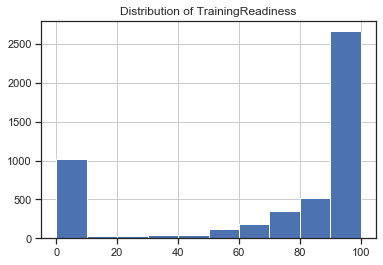

In [51]:
wellness_df['TrainingReadiness'].hist()
plt.title('Distribution of TrainingReadiness')
plt.show()

Training readiness has an interesting distribution where most players are 100% ready but the second most common response is close to 0. We also see a tail to the left of 100% with a small number of player tending down to about 50% readiness.

It is interesting that most players see themselves as completely ready or not at all ready to train. I wonder what causes the players to be 0% ready to train? Is there are correlation to one of the binary variables like illness? We will explore correlations between all the wellness columns later in this notebook.

To see if there is some factor of wellness that is affecting training readiness, we could look at the Monitoring Scores of those who marked themselves with low vs high Training Readiness.

In [52]:
low_readiness_df = wellness_df[wellness_df['TrainingReadiness'] <= 10]
high_readiness_df = wellness_df[wellness_df['TrainingReadiness'] >= 80]

In [53]:
low_readiness_df['MonitoringScore'].mean()

17.680311890838208

In [54]:
low_readiness_df['MonitoringScore'].std()

3.908857022161638

In [55]:
high_readiness_df['MonitoringScore'].mean()

18.78831658291457

In [56]:
high_readiness_df['MonitoringScore'].std()

3.589759467852359

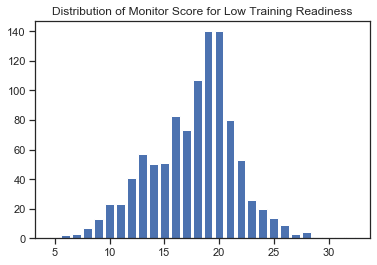

In [57]:
plt.bar(np.sort(low_readiness_df['MonitoringScore'].unique()), low_readiness_df['MonitoringScore'].value_counts().sort_index())
plt.title('Distribution of Monitor Score for Low Training Readiness')
plt.show()


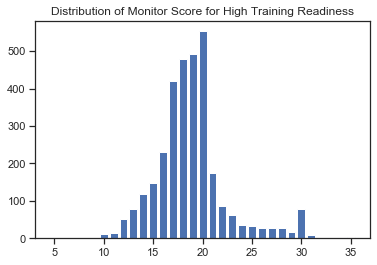

In [58]:
plt.bar(np.sort(high_readiness_df['MonitoringScore'].unique()), high_readiness_df['MonitoringScore'].value_counts().sort_index())
plt.title('Distribution of Monitor Score for High Training Readiness')
plt.show()


It seems like the Monitoring Score of those with low Training Readiness tends to be lower than the Monitoring Score of those with high Training Readiness. To see the effect size of this relationship, we can compute the repeated measures correlation between Monitoring Score and Training Readiness.

In [59]:
pg.rm_corr(data=wellness_df, x='MonitoringScore', y='TrainingReadiness', subject='PlayerID')


,r,dof,pval,CI95%,power
rm_corr,0.227,4977,2.639584e-59,"[0.2, 0.25]",1.0


We see that there is a weak positive correlation between monitoring score and training readiness. Higher monitoring score is related to higher training readiness, however, training readiness still measures aspects of wellness not covered by the monitoring score. Thus, we should keep it in our dataset for now.

### Monitoring Score

This is an aggregation of the 5 scale values. We could either use this or the 5 scales on their own but it would not be appropriate to use both. Given that we will later use factor analysis to see if our data can be represented as latent factors, we should ignore this summary column and see if the columns that it is made from are actually all related.

In [60]:
full_wellness_df = wellness_df.copy() # Save full df for later
wellness_df = wellness_df.drop(columns=['MonitoringScore'])
non_imputed_wellness_df = non_imputed_wellness_df.drop(columns=['MonitoringScore'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,1,3,0,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,0,3,0,3,0
2,2018-07-21,3,3,3,5,4,8.00,4,1,3,1,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,1,3,0,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,1,3,1,2,100


In [61]:
wellness_df.shape


(4995, 13)

After all my cleaning, I am left with 4995 observations and 11 observed variables for factor analysis (date and player id) are not useful in this case.

In [62]:
wellness_df.columns

Index(['Date', 'PlayerID', 'Fatigue', 'Soreness', 'Desire', 'Irritability',
       'SleepHours', 'SleepQuality', 'Pain', 'Illness', 'Menstruation',
       'Nutrition', 'TrainingReadiness'],
      dtype='object')

### Repeated Measures Correlations

We have performed repeated measures correlations on some of the columns as we explored to wellness data. To get a full picture of how the wellness data columns relate to each other, we will now perform the repeated measures correlation for all relevant columns (excluding Date and Player ID). Unfortunately, the package we are using does not give us a repeated measures correlation matrix so we will iteratively compute the correlations in a loop and then summarize all the correlations above `0.3`.

In [63]:
for i in wellness_df.columns:
    if i == 'Date' or i == 'PlayerID':
        continue
        
    for j in wellness_df.columns:
        if j == 'Date' or j == 'PlayerID' or i == j:
            continue
            
        print('Repeated Measures Correlation Result for {} and {}'.format(i, j))
        print(pg.rm_corr(data=wellness_df, x=i, y=j, subject='PlayerID'))

Repeated Measures Correlation Result for Fatigue and Soreness
             r   dof           pval        CI95%  power
rm_corr  0.425  4977  4.349049e-218  [0.4, 0.45]    1.0
Repeated Measures Correlation Result for Fatigue and Desire
             r   dof           pval         CI95%  power
rm_corr  0.491  4977  2.047966e-300  [0.47, 0.51]    1.0
Repeated Measures Correlation Result for Fatigue and Irritability
             r   dof           pval         CI95%  power
rm_corr  0.382  4977  5.424256e-173  [0.36, 0.41]    1.0
Repeated Measures Correlation Result for Fatigue and SleepHours
             r   dof          pval         CI95%  power
rm_corr  0.201  4977  2.500877e-46  [0.17, 0.23]    1.0
Repeated Measures Correlation Result for Fatigue and SleepQuality
             r   dof           pval        CI95%  power
rm_corr  0.423  4977  6.015440e-215  [0.4, 0.45]    1.0
Repeated Measures Correlation Result for Fatigue and Pain
             r   dof      pval         CI95%  power
rm_corr 

             r   dof      pval          CI95%  power
rm_corr  0.001  4977  0.960987  [-0.03, 0.03]   0.05
Repeated Measures Correlation Result for SleepHours and Nutrition
             r   dof      pval         CI95%  power
rm_corr  0.061  4977  0.000016  [0.03, 0.09]  0.991
Repeated Measures Correlation Result for SleepHours and TrainingReadiness
             r   dof      pval           CI95%  power
rm_corr -0.036  4977  0.010345  [-0.06, -0.01]  0.727
Repeated Measures Correlation Result for SleepQuality and Fatigue
             r   dof           pval        CI95%  power
rm_corr  0.423  4977  6.015782e-215  [0.4, 0.45]    1.0
Repeated Measures Correlation Result for SleepQuality and Soreness
             r   dof          pval        CI95%  power
rm_corr  0.178  4977  1.501565e-36  [0.15, 0.2]    1.0
Repeated Measures Correlation Result for SleepQuality and Desire
             r   dof          pval        CI95%  power
rm_corr  0.231  4977  2.345194e-61  [0.2, 0.26]    1.0
Repeated Mea

             r   dof      pval        CI95%  power
rm_corr  0.029  4977  0.042583  [0.0, 0.06]  0.527
Repeated Measures Correlation Result for Nutrition and Menstruation
             r   dof      pval          CI95%  power
rm_corr  0.001  4977  0.969623  [-0.03, 0.03]   0.05
Repeated Measures Correlation Result for Nutrition and TrainingReadiness
            r   dof          pval         CI95%  power
rm_corr  0.12  4977  1.524307e-17  [0.09, 0.15]    1.0
Repeated Measures Correlation Result for TrainingReadiness and Fatigue
             r   dof          pval         CI95%  power
rm_corr  0.158  4977  2.685141e-29  [0.13, 0.19]    1.0
Repeated Measures Correlation Result for TrainingReadiness and Soreness
             r   dof          pval         CI95%  power
rm_corr  0.101  4977  8.303311e-13  [0.07, 0.13]    1.0
Repeated Measures Correlation Result for TrainingReadiness and Desire
             r   dof           pval        CI95%  power
rm_corr  0.324  4977  6.993504e-122  [0.3, 0.35]

#### Correlated Measures

* Fatigue and Soreness (0.425)  
* Fatigue and Desire (0.491)  
* Fatigue and Irritability (0.382)  
* Fatigue and Sleep Quality (0.423)  
* Soreness and Desire (0.379)
* Desire and Irritability (0.491)
* Desire and Soreness (0.379)
* Desire and TrainingReadiness (0.324)
* Irritability and SleepQuality (0.307)

The elements of the monitor score are all correlated with each other which supports the idea that it is measuring the same latent variable. We will test this conclusion when we perform factor analysis. It is further interesting that nothing is correlated to Sleep Hours but measures such as Fatigue and Irritability are correlated with Sleep Quality. So sleep quality seems to be a better measure of one's sleeps over their sleep hours. At first, I thought this was because these athletes probably sleep for the same amount of time each night but that us not the case. The SD of Sleep Hours is 1.42 but it is only 1.17 for Sleep Quality. So Sleep Hours has more variance but is still not a good measure for things related to sleep, such as fatigue and Irritability.

I wonder how exactly Sleep Hours is computed. For example, when you "go to bed" is not when you fall asleep. Is sleep measure by bedtime and wake time or by tracking the actual time one falls asleep or wakes up.

In [64]:
wellness_df['SleepHours'].std()

1.417490411895022

In [65]:
wellness_df['SleepQuality'].std()

1.1707329112441724

## Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal component analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading matrices. We can also see which factors are most important by their eigenvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

Thus, we will use factor analysis to point us to relevant features correlated to the latent variables in the wellness data for use later in our analysis. We will also aim to combine these relevant features of wellness into a single wellness score which will let us find the high level relationships between wellness, load, and performance.

In [66]:
wellness_df.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,1,3,0,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,0,3,0,3,0
2,2018-07-21,3,3,3,5,4,8.00,4,1,3,1,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,1,3,0,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,1,3,1,2,100


### Averaging Over Different Dates

We cannot perform factor analysis using data gathered at different dates. So, for each player, we need to average all their values. In doing so, we can interpret most columns as "Average X", i.e. "Average Sleep Hours". However, we cannot do this for the binary categorical columns. We could instead interpret these as probabilities, i.e., probability of being ill.

In [67]:
wellness_df = wellness_df.drop(columns=['Date'])
non_imputed_wellness_df = non_imputed_wellness_df.drop(columns=['Date'])
wellness_df = wellness_df.groupby('PlayerID',as_index = False).mean()
non_imputed_wellness_df = non_imputed_wellness_df.groupby('PlayerID',as_index = False).mean()
wellness_df


,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,1,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.974763,2.895899,0.842271,2.984227,21.435331
1,2,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.794643,2.958333,0.812500,2.589286,11.651786
2,3,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.973913,3.000000,0.881159,3.000000,98.115942
3,4,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.993506,2.983766,0.853896,2.980519,66.996753
4,5,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.683398,2.768340,0.888031,1.996139,65.637066
5,6,3.694656,3.438931,3.961832,3.942748,8.471374,3.984733,0.996183,2.946565,0.858779,2.782443,67.156489
6,7,3.073314,3.087977,3.797654,3.697947,9.212610,3.862170,0.929619,2.926686,0.868035,2.891496,93.460411
7,8,3.737705,3.537705,3.734426,4.367213,8.194262,4.016393,0.744262,2.442623,0.927869,2.419672,53.704918
8,9,4.877828,4.565611,4.886878,4.914027,9.160633,4.900452,0.995475,2.945701,0.895928,2.479638,77.104072
9,10,2.954683,2.978852,3.794562,3.824773,8.374622,2.933535,0.274924,2.489426,0.788520,2.513595,74.244713


Now that we have averaged over all the days for each player, we can drop the player id column.

In [68]:
player_id_series = wellness_df['PlayerID'] # Also save this for later
wellness_df = wellness_df.drop(columns=['PlayerID'])
non_imputed_wellness_df = non_imputed_wellness_df.drop(columns=['PlayerID'])


In [69]:
wellness_df.shape

(17, 11)

We see that we have averaged over the 17 players in the dataset.

### Adequacy Tests

There are two tests we can perform to see if a dataset is suitable for factor analysis.

#### Bartlett’s Test

This test makes sure the observed variables are correlated. It tests if the observed correlation matrix is statistically different from the identity matrix (ie, are all correlations between observations 0). A significant result means we have correlation between the observations.

In [70]:
chi_square_value,p_value = calculate_bartlett_sphericity(wellness_df)
chi_square_value, p_value


(116.96551634104655, 6.414729983140542e-07)

#### Kaiser-Meyer-Olkin Test

The statistic given by this test is a measure of the proportion of variance among variables that might be common variance. We are looking for an overall score from the model above `0.5`.

In [71]:
kmo_all,kmo_model=calculate_kmo(wellness_df)
kmo_all, kmo_model


(array([0.64867746, 0.8003926 , 0.56751788, 0.57756778, 0.35975405,
        0.88448718, 0.45718562, 0.39360699, 0.4318835 , 0.39729764,
        0.19594677]), 0.5816376555684316)

The data just barely passes the KMO test but passes Bartlett's test by a large margin.

From the perspective of the KMO test, training readiness is the least adequate of all observations.

### Dealing With Pain, Illness, and Menstruation

The scale of all variables are such that larger values indicate better wellness. However, the Pain, Illness, and Menstruation variables are encoding the probability that one is exhibiting the given trait, which all seem to decrease wellness. Thus, I should take the inverse of these probabilities to represent the probability that the players are not exhibiting this trait so wellness can be interpreted in the same way across all factors.

In [72]:
#wellness_df['Pain'] = 1 - wellness_df['Pain']
#wellness_df['Illness'] = 1 - wellness_df['Illness']
#wellness_df['Menstruation'] = 1 - wellness_df['Menstruation']
pca_df = wellness_df.copy() # Added in for PCA at end of document
#non_imputed_wellness_df['Pain'] = 1 - non_imputed_wellness_df['Pain']
#non_imputed_wellness_df['Illness'] = 1 - non_imputed_wellness_df['Illness']
#non_imputed_wellness_df['Menstruation'] = 1 - non_imputed_wellness_df['Menstruation']
wellness_df


,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.974763,2.895899,0.842271,2.984227,21.435331
1,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.794643,2.958333,0.812500,2.589286,11.651786
2,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.973913,3.000000,0.881159,3.000000,98.115942
3,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.993506,2.983766,0.853896,2.980519,66.996753
4,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.683398,2.768340,0.888031,1.996139,65.637066
5,3.694656,3.438931,3.961832,3.942748,8.471374,3.984733,0.996183,2.946565,0.858779,2.782443,67.156489
6,3.073314,3.087977,3.797654,3.697947,9.212610,3.862170,0.929619,2.926686,0.868035,2.891496,93.460411
7,3.737705,3.537705,3.734426,4.367213,8.194262,4.016393,0.744262,2.442623,0.927869,2.419672,53.704918
8,4.877828,4.565611,4.886878,4.914027,9.160633,4.900452,0.995475,2.945701,0.895928,2.479638,77.104072
9,2.954683,2.978852,3.794562,3.824773,8.374622,2.933535,0.274924,2.489426,0.788520,2.513595,74.244713


### Choosing the Number of Factors

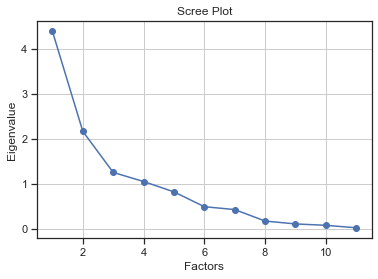

In [73]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(wellness_df) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,wellness_df.shape[1]+1),ev)
plt.plot(range(1,wellness_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


The elbow seems to form at the third factor so I will use 3 factors in my analysis.

### Perform Factor Analysis

In [74]:
list(wellness_df.columns)

['Fatigue',
 'Soreness',
 'Desire',
 'Irritability',
 'SleepHours',
 'SleepQuality',
 'Pain',
 'Illness',
 'Menstruation',
 'Nutrition',
 'TrainingReadiness']

In [75]:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')

fa.fit(wellness_df)
fa.loadings_


array([[ 0.99335799,  0.11138695,  0.08884982],
       [ 0.86689953,  0.14049917, -0.10103337],
       [ 0.76959397,  0.05748282,  0.03479729],
       [ 0.88167378, -0.00561019,  0.08171634],
       [ 0.19577453,  0.37047252,  0.01844416],
       [ 0.7844147 ,  0.30196335,  0.20579328],
       [ 0.02969643,  0.76986303,  0.29240082],
       [ 0.02623362,  0.97599987,  0.05925815],
       [ 0.27747682, -0.02975125,  0.76518849],
       [-0.39093356,  0.21909658,  0.4940861 ],
       [ 0.0114892 ,  0.06059035,  0.20523662]])

The rule of thumb for seeing if a observation is related to a factor is a loading of `0.7` or higher.

From this we see that `Fatigue`, `Soreness`, `Desire`, `Irritability`, and `SleepQuality` all relate to the first factor. This is interesting because these are the observations that made up the Monitor Score. We can interpret this as subjective wellness as they are all self reported values.

The second is related to `Pain` and `Illness`. We can interpret this as objective wellness.

The third factor is only related to `Menstruation` and to a lesser extent `Nutrition`. We can interpret this factor as representing Mentration.

In [76]:
fa.get_factor_variance()

(array([3.99305703, 1.86173905, 1.02944785]),
 array([0.36300518, 0.169249  , 0.09358617]),
 array([0.36300518, 0.53225419, 0.62584036]))

This 3 factor model explains about `62%` of the variance in the data which is adequate.

### Factor Analysis With Non-Imputed Data

As mentioned during our presentation, imputing the nutrition data might affect our factor analysis.

In [77]:
non_imputed_wellness_df.columns

Index(['Fatigue', 'Soreness', 'Desire', 'Irritability', 'SleepHours',
       'SleepQuality', 'Pain', 'Illness', 'Menstruation', 'Nutrition',
       'TrainingReadiness'],
      dtype='object')

In [78]:
fa_non_imputed = FactorAnalyzer(n_factors=3, rotation='varimax')

fa_non_imputed.fit(non_imputed_wellness_df)
fa_non_imputed.loadings_

array([[ 0.99331801,  0.11026136,  0.09063911],
       [ 0.86776123,  0.13979281, -0.10403713],
       [ 0.76863531,  0.05532832,  0.04152568],
       [ 0.88199956, -0.00504349,  0.07917245],
       [ 0.19572868,  0.36931924,  0.01983908],
       [ 0.78479007,  0.30224301,  0.20455423],
       [ 0.03095082,  0.76781679,  0.28875663],
       [ 0.02664974,  0.98063229,  0.05380147],
       [ 0.27684725, -0.02488507,  0.75654431],
       [-0.39217745,  0.23778501,  0.48417433],
       [ 0.00943702,  0.05994114,  0.21684416]])

We see that when we use non-imputed data, the results of factor analysis are largely the same. This is a good sign because it means our imputation of the nutrition data did not change the essence of the data much.

## Factor Analysis Conclusions

Given the wellness data, we can summarize it into summary measures by taking the `Monitoring Score`, along with the categorical variables `Pain`, `Illness`, `Menstruation`, and `Nutrition`. We add in nutrition because it was somewhat related to the third factor and we would rather be over inclusive as opposed to leaving out important features at this stage of our analysis. Since each variable is on a different scale, we should standardize the values before adding them up so they are equally weighted in the final wellness score.

## Summarize Wellness

In [79]:
full_wellness_df.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,1,3,0,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,19,0,3,0,3,0
2,2018-07-21,3,3,3,5,4,8.00,4,19,1,3,1,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,15,1,3,0,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,20,1,3,1,2,100


In [80]:
processed_wellness_df = full_wellness_df.copy()[['Date', 'PlayerID', 'MonitoringScore', 'Fatigue', 'Soreness', 'Desire', 'Irritability', 'SleepHours', 'SleepQuality', 'Menstruation', 'Pain', 'Illness', 'Nutrition', 'TrainingReadiness']]
scaled_wellness_values = StandardScaler().fit_transform(processed_wellness_df[['MonitoringScore', 'Pain', 'Illness', 'Nutrition', 'Menstruation', 'TrainingReadiness']])
processed_wellness_df['StandardizedMonitoringScore'] = scaled_wellness_values[:, 0]
processed_wellness_df['StandardizedPain'] = scaled_wellness_values[:, 1]
processed_wellness_df['StandardizedIllness'] = scaled_wellness_values[:, 2]
processed_wellness_df['StandardizedNutrition'] = scaled_wellness_values[:, 3]
processed_wellness_df['StandardizedMenstruation'] = scaled_wellness_values[:, 3]
processed_wellness_df['StandardizedTrainingReadiness'] = scaled_wellness_values[:, 4]
processed_wellness_df['wellness'] = processed_wellness_df['StandardizedMonitoringScore'] + processed_wellness_df['StandardizedPain'] + processed_wellness_df['StandardizedIllness'] + processed_wellness_df['StandardizedMenstruation']
processed_wellness_df['WellnessAffectedByLoad'] = processed_wellness_df['StandardizedMonitoringScore'] + processed_wellness_df['StandardizedPain'] + processed_wellness_df['StandardizedIllness'] + processed_wellness_df['StandardizedNutrition'] + processed_wellness_df['StandardizedTrainingReadiness']

processed_wellness_df.head()

,Date,PlayerID,MonitoringScore,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Menstruation,...,Nutrition,TrainingReadiness,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedMenstruation,StandardizedTrainingReadiness,wellness,WellnessAffectedByLoad
0,2018-07-21,1,13,3,3,2,3,8.00,2,0,...,3,0,-1.448934,0.363863,0.330081,0.716267,0.716267,-2.456667,-0.038724,-2.495390
1,2018-07-21,2,19,4,3,4,4,8.00,4,0,...,3,0,0.170479,-2.748287,0.330081,0.716267,0.716267,-2.456667,-1.531461,-3.988127
2,2018-07-21,3,19,3,3,5,4,8.00,4,1,...,3,100,0.170479,0.363863,0.330081,0.716267,0.716267,0.407056,1.580689,1.987745
3,2018-07-21,4,15,2,3,5,4,6.50,1,0,...,3,95,-0.909130,0.363863,0.330081,0.716267,0.716267,-2.456667,0.501081,-1.955586
4,2018-07-21,5,20,5,3,4,4,7.25,4,1,...,2,100,0.440381,0.363863,0.330081,-1.221844,-1.221844,0.407056,-0.087520,0.319536


Note that we added 2 summary measures of wellness. The first is what we get if we follow the logic of our factor analysis. The second is meant to be used when we compare wellness and training load. Given that menstruation is not dependent on training load, it would in appropriate for the wellness summary we use to be influcenced by menstruation as we intend for wellness to be the dependent variable in this case.

### Saved Processed Wellness Data To File

In [81]:
processed_wellness_df.to_csv('./processed_data/processed_wellness.csv')

In [82]:
processed_wellness_df[['PlayerID', 'wellness', 'WellnessAffectedByLoad']].groupby('PlayerID').mean()

,wellness,WellnessAffectedByLoad
PlayerID,,
1,0.410688,0.366053
2,0.164388,0.034495
3,1.195961,1.262690
4,1.053156,1.041811
5,-1.708920,-1.622513
6,1.023971,1.026608
7,0.574152,0.603297
8,-1.583206,-1.382714
9,1.815218,1.924239


We see that in general, both our summary measures of wellness are similar.

## Visualize Wellness Using PCA

We want to try and visualize the clusters of players so we will use PCA to plot the average player wellness data on 2 principal components. This gives us a ground truth on the similarity in wellness between players and can help us assess the quality of our wellness summary measures.

In [83]:
pca_df.head()

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.974763,2.895899,0.842271,2.984227,21.435331
1,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.794643,2.958333,0.812500,2.589286,11.651786
2,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.973913,3.000000,0.881159,3.000000,98.115942
3,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.993506,2.983766,0.853896,2.980519,66.996753
4,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.683398,2.768340,0.888031,1.996139,65.637066


In [84]:
pca_standard_scaler = StandardScaler()
pca_df[pca_df.columns] = pca_standard_scaler.fit_transform(pca_df)
pca_df

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,-1.367946,-0.245809,-2.728568,-0.196525,0.075544,-0.405559,0.468923,0.163069,-0.307996,1.142769,-2.035719
1,0.484052,-0.301253,0.443991,0.438675,0.782637,0.377043,-0.529892,0.553648,-0.859682,-0.040733,-2.447402
2,-0.233180,-0.514008,-0.833933,-0.069999,-1.671097,0.056383,0.464208,0.814308,0.412632,1.190035,1.190932
3,-0.309293,0.263590,0.098244,-0.988991,-0.863143,-1.414341,0.572859,0.712752,-0.092579,1.131659,-0.118535
4,0.523049,0.843420,0.854211,-0.112742,-1.575015,-0.053089,-1.146776,-0.634923,0.539966,-1.818188,-0.175750
5,0.341780,0.043808,0.150228,-0.179263,-0.434336,0.166383,0.587702,0.480026,-0.002102,0.538091,-0.111814
6,-0.696934,-0.703057,-0.168617,-0.902921,1.115077,-0.021678,0.218585,0.355668,0.169429,0.864885,0.995032
7,0.413745,0.254008,-0.291409,1.075502,-1.013586,0.214963,-0.809266,-2.672557,1.278195,-0.549006,-0.677844
8,2.319716,2.441490,1.946727,2.691944,1.006430,1.571468,0.583775,0.474624,0.686298,-0.369309,0.306772
9,-0.895252,-0.935285,-0.174622,-0.528009,-0.636577,-1.446580,-3.411868,-2.379765,-1.304058,-0.267552,0.186452


In [85]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_df)
principal_components


array([[-2.22879566e+00, -9.78179524e-01],
       [ 5.16621003e-01,  3.96763049e-01],
       [-8.09451011e-01, -1.20412800e+00],
       [-1.15416238e+00, -9.26623749e-01],
       [ 7.11091561e-01,  2.38690944e+00],
       [ 2.18462421e-01, -6.79261069e-01],
       [-8.68002204e-01, -1.47457888e+00],
       [ 3.90985076e-01,  2.50528003e+00],
       [ 5.11076852e+00,  1.40340238e-01],
       [-2.73985461e+00,  3.56187426e+00],
       [-3.03314641e+00, -5.77101244e-01],
       [ 6.70100487e-01,  6.63291943e-01],
       [-3.30537459e-04, -1.40432596e+00],
       [ 2.41097572e-01, -1.79070392e+00],
       [ 4.09124544e+00, -1.65176657e-01],
       [-2.19192478e+00, -6.26922031e-02],
       [ 1.07529552e+00, -3.91687753e-01]])

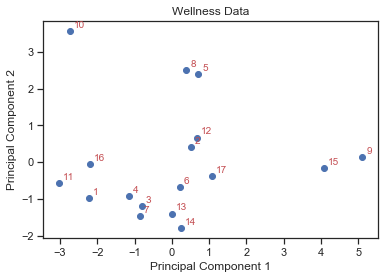

In [86]:
HORIZONTAL_OFFSET = 0.1
VERTICAL_OFFSET = 0.1

fig, ax = plt.subplots()
ax.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('Wellness Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


for i in range(len(player_id_series)):
    ax.annotate(str(i + 1), (principal_components[i, 0] + HORIZONTAL_OFFSET, principal_components[i, 1] + VERTICAL_OFFSET), color='r')
plt.show()

Looking back at the average wellness summaries, we see that many of these patterns are present in the PCA visualization as well. For example, players 8 and 5 have similar scores as do player 2 and 12. We even further notice that players 2 and 12 have average scores as they are close to the center of the PCA plot and in our wellness summaries, their scores are close to 0.

## Conclusion

In this notebook, we explored the wellness data and used factor analysis to create summary measures of wellness. We used PCA to visualize the wellness data and used the patterns in the PCA decomposition to check the quality of our wellness summaries. Many patterns on the PCA visualization carry over to our summary measures which gives us confidence that they are good summaries of the wellness data.

Using the results from our factor analysis, it seems that the features that best represent wellness are: monitoring score, pain, illness, nutrition, and menstruation. Ming had mentioned that sleep hours is known to affect performance, so although our factor analysis did not find that this was an important feature, we should include it as well as we want to incorporate domain knowledge in our feature selection as well.